# Imports

In [1]:
from dataset import MyData
from model import Net
from config import device, PATH_TO_TARGET0, PATH_TO_TARGET, PATH_TO_INPUT
from helper import downscale_map, split_map
from color_script import get_result

import torch
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import glob
import os 
import matplotlib.image as mpimg
import pandas as pd
from matplotlib import gridspec


Selected devie is cuda:0


# Big Test 1



## Map splitting visualization

In [ ]:
@interact(path=glob.glob(PATH_TO_TARGET0+'*'), x_parts=(2, 10), scale_coef=(0.5, 1, 0.05), color=(150, 255))
def real_time_split(path=PATH_TO_TARGET0+'0001.png', x_parts=5, scale_coef=0.85, color=255):
    _ = split_map(path=path, x_parts=x_parts, scale_coef=scale_coef, color=color, need_plot=True)

## Preparing folders

In [ ]:
for img_name in os.listdir(PATH_TO_TARGET0):
    _, ans = get_result(PATH_TO_TARGET0 + img_name)
    ans.save(PATH_TO_TARGET + img_name)
    
    img = split_map(path=PATH_TO_TARGET0 + img_name, x_parts=5, scale_coef=0.85, color=255,  need_plot=False)
    plt.imsave(PATH_TO_INPUT + img_name, img, cmap='gray')

## Map Cascade

### Downscale visualization

In [ ]:
@interact(path_to_file=glob.glob('./data/*.abz'))
def s_(path_to_file):
    dataset1 = MyData(path_to_file=path_to_file, mode='abz', mode_3d='cylinder', radius=10, reduce_fctor=1, need_help=False)
    normal_img_array_1 = 1 - np.array(dataset1.img_array, dtype='float64') / 255.
    map_cascade_1 = [downscale_map(normal_img_array_1, sq_size=2 ** x) for x in [7, 6, 5, 3, 2]]

    # convolve = np.vectorize(np.convolve, signature='(n),(m)->(k)')
    # map_cascade = [(1 - convolve(convolve(normal_img_array, np.ones((i))).T, np.ones((i))).T) > 0 for i in range(200, 0, -50)]

    for cas_map in map_cascade_1:
        plt.imshow(cas_map, cmap="gray")
        plt.title(f'{cas_map.shape}')
        plt.show()
        

### Loop for training many models

In [48]:
def big_test(path_to_test='./BIG_TEST_MAP_CASCADE/'):
    for path_to_file in glob.glob('./data/*.abz'):
        filename = path_to_file.split('\\')[-1]
        cur_dir = path_to_test + filename[:-4]
        os.makedirs(cur_dir, exist_ok=True)
        
        for radius in [1., 2., 5., 10., 15., 20.]:
            cur_dir = path_to_test + filename[:-4] + f'/radius_{radius}'
            os.makedirs(cur_dir, exist_ok=True)

            dataset1 = MyData(path_to_file=path_to_file, mode='abz', mode_3d='cylinder', radius=radius, reduce_fctor=1, need_help=False)
            dataset_list = [dataset1]
            normal_img_array = 1 - np.array(dataset1.img_array, dtype='float64') / 255.
            map_cascade = [downscale_map(normal_img_array, sq_size=2**x) for x in [7, 6, 5, 3, 2]]
            
            for i, cas_map in enumerate(map_cascade):
                dataset1 = MyData(path_to_file=255 * cas_map, mode='2img', mode_3d='cylinder', radius=radius, reduce_fctor=1, need_help=False)

                dataset_list = [dataset1]
                model = Net(dataset_list=dataset_list, lr=1e-3)
                model.to(device)
                # summary(model, input_size=(sum([len(x) for x in model.data_list]), 3))

                if i:
                    model.load_state_dict(torch.load(cur_dir+f'/{i}_state_dict.pt'))
                # _ = model.test_model(model.data_list, need_plot=True)
                # dataset1.show_image()
                model.start_training(num_epochs=5e+3, my_weight=0.1, need_plot=False, need_save=False)
                model.save_state_dict(cur_dir+f'/{i+1}_state_dict.pt')
        
# big_test()

### Save results in the form of image

In [ ]:
for map_name in os.listdir('./BIG_TEST_MAP_CASCADE/'):
    grid = plt.GridSpec(4, 3)
    plt.figure(figsize=(15, 15))
    # plt.suptitle(f'Visualization of the function $f(x,y,z)$ on {map_name}')

    for i, radius_path in enumerate(os.listdir(f'./BIG_TEST_MAP_CASCADE/{map_name}')):
        radius = float(radius_path.split('_')[-1])

        dataset = MyData(path_to_file=f'./data/{map_name}.abz', mode='abz', mode_3d='cylinder', radius=radius, reduce_fctor=1, need_help=False)
        model=Net(dataset_list=[dataset], lr=1e-3).to(device)
        model.load_state_dict(torch.load(f'./BIG_TEST_MAP_CASCADE/{map_name}/{radius_path}/5_state_dict.pt'))
        with torch.no_grad():
            output_list = [model(input.to(device)).cpu().detach() for input in model.data_list]
            loss = model.compute_loss(output_list, my_weight=0.1)
        plt.subplot(grid[i // 3, i % 3])
        plt.imshow(output_list[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
        plt.title(f'Radius = {radius}, Loss = {loss:.3f}')
    plt.subplot(grid[2, :])
    # plt.title(f'Target map {map_name}')
    path_to_target_img = f'./data/{map_name}.gif'
    plt.imshow(mpimg.imread(path_to_target_img), cmap='gray')
    plt.axis('off')
    plt.subplot(grid[3, :])
    plt.title(f'Original map {map_name}')
    plt.imshow(dataset.img_array, cmap='gray')
    
    os.makedirs('./BIG_TEST_MAP_CASCADE_results', exist_ok=True)
    plt.savefig(f'./BIG_TEST_MAP_CASCADE_results/{map_name}.png', facecolor='white')


### Make table of results

In [69]:
res_dict = {}
for map_name in os.listdir('./BIG_TEST_MAP_CASCADE/'):
    res_dict[map_name] = {}
    for radius_path in os.listdir(f'./BIG_TEST_MAP_CASCADE/{map_name}'):
        radius = float(radius_path.split('_')[-1])
        dataset = MyData(path_to_file=f'./data/{map_name}.abz', mode='abz', mode_3d='cylinder', radius=radius, reduce_fctor=1, need_help=False)
        model=Net(dataset_list=[dataset], lr=1e-3).to(device)
        model.load_state_dict(torch.load(f'./BIG_TEST_MAP_CASCADE/{map_name}/{radius_path}/5_state_dict.pt'))
        with torch.no_grad():
            output_list = [model(input.to(device)).cpu().detach() for input in model.data_list]
            loss = model.compute_loss(output_list, my_weight=0.1)
        res_dict[map_name][radius] = loss.numpy()

In [70]:
df = pd.DataFrame.from_dict(res_dict, orient='index', columns=[1., 2., 5., 10., 15., 20.])
df

,1.0,2.0,5.0,10.0,15.0,20.0
sn1996k1904eng,0.17910649,0.13343988,0.16337517,0.12618695,0.1429933,0.21951117
sn1996k1905eng,0.3080644,0.30417284,0.17025696,0.24258286,0.1130567,0.08923017
sn1996k1906eng,0.18068337,0.11606892,0.19258796,0.09723622,0.17927095,0.0938478
sn1996k1907eng,0.23718216,0.37504908,0.2142726,0.3711627,0.2098669,0.19954531
sn1996k1908eng,0.13678554,0.15115261,0.07683112,0.08129287,0.6223429,0.078284696
sn1996k1909eng,0.114870355,0.25997916,0.25830814,0.13832031,0.2772987,0.09218259
sn1996k1910eng,0.7841412,0.7093341,0.16984908,0.16212864,0.16853276,0.16014926
sn1996k1911eng,0.21512854,0.17002791,0.17895973,0.13767628,0.21002138,0.724503
sn1996k1912eng,0.16261458,0.19972321,0.25447634,0.14700937,0.15166387,0.14492929
sn1996k1913eng,0.20427893,0.1648998,0.70845187,0.14818043,0.14949252,0.17160212


In [ ]:
def plot_df_by_rows(df):
    grid = plt.GridSpec(df.shape[0], 1)
    plt.figure(figsize=(10, 100))
    for i, row in enumerate(df.iterrows()):
        plt.subplot(grid[i, 0])
        plt.title(row[0])
        plt.plot(row[1].index, row[1].values)
        plt.xlabel('Radius')
        plt.ylabel('Loss')
    plt.show()
plot_df_by_rows(df)

# Big Test 2

## 25 tests on same image

Stage 1/25 is done! Loss = 0.205
Stage 2/25 is done! Loss = 0.206
Stage 3/25 is done! Loss = 0.188
Stage 4/25 is done! Loss = 0.162
Stage 5/25 is done! Loss = 0.171
Stage 6/25 is done! Loss = 0.181
Stage 7/25 is done! Loss = 0.206
Stage 8/25 is done! Loss = 0.188
Stage 9/25 is done! Loss = 0.179
Stage 10/25 is done! Loss = 0.176
Stage 11/25 is done! Loss = 0.226
Stage 12/25 is done! Loss = 0.187
Stage 13/25 is done! Loss = 0.176
Stage 14/25 is done! Loss = 0.210
Stage 15/25 is done! Loss = 0.229
Stage 16/25 is done! Loss = 0.188
Stage 17/25 is done! Loss = 0.154
Stage 18/25 is done! Loss = 0.191
Stage 19/25 is done! Loss = 0.266
Stage 20/25 is done! Loss = 0.168
Stage 21/25 is done! Loss = 0.216
Stage 22/25 is done! Loss = 0.173
Stage 23/25 is done! Loss = 0.204
Stage 24/25 is done! Loss = 0.181
Stage 25/25 is done! Loss = 0.221


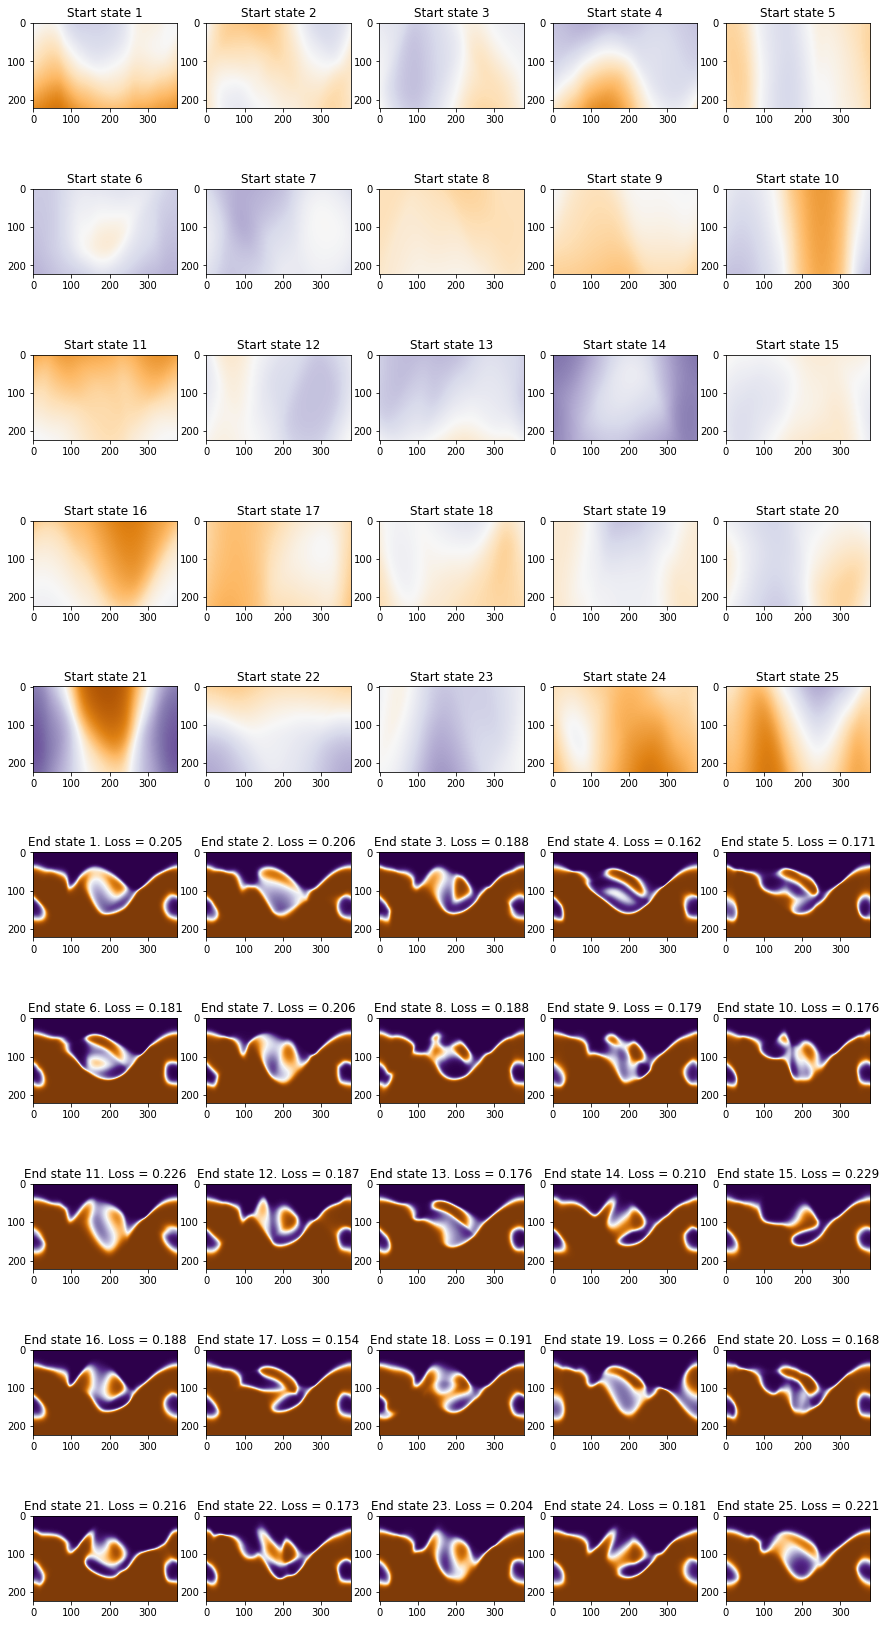

In [2]:
NUMBER_OF_EPOCHS = 2e+3
NUM_TESTS = 5
LR = 1e-3

dataset = MyData(path_to_file='./imgs/2.png', mode='img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
dataset_list = [dataset]

model = Net(dataset_list=dataset_list, lr=LR)

model.to(device)


gs = gridspec.GridSpec(2 * NUM_TESTS, NUM_TESTS)


plt.figure(figsize=(15, 30))
for i in range(NUM_TESTS ** 2):
    model = model.restart_model(lr=LR)
    start_state = model.test_model()
    model.start_training(num_epochs=NUMBER_OF_EPOCHS, my_weight=0.1, need_plot=False, need_save=False)
    end_state = model.test_model()

    # start_state = end_state = [torch.zeros(dataset.img_array.shape).flatten()]

    plt.subplot(gs[i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(start_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    plt.title(f'Start state {i+1}')

    plt.subplot(gs[NUM_TESTS + i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(end_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    loss = model.loss_dict['loss'][-1]
    plt.title(f'End state {i + 1}. Loss = {loss:.3f}')

    print(f'Stage {i+1}/{NUM_TESTS ** 2} is done! Loss = {loss:.3f}')


    

## Weights initialization

### $\mathcal{U}[0,1]$

In [4]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

Stage 1/25 is done! Loss = 0.263
Stage 2/25 is done! Loss = 0.430
Stage 3/25 is done! Loss = 0.285
Stage 4/25 is done! Loss = 0.261
Stage 5/25 is done! Loss = 0.348
Stage 6/25 is done! Loss = 0.242
Stage 7/25 is done! Loss = 0.441
Stage 8/25 is done! Loss = 0.291
Stage 9/25 is done! Loss = 0.236
Stage 10/25 is done! Loss = 0.358
Stage 11/25 is done! Loss = 0.796
Stage 12/25 is done! Loss = 0.371
Stage 13/25 is done! Loss = 0.301
Stage 14/25 is done! Loss = 0.238
Stage 15/25 is done! Loss = 0.364
Stage 16/25 is done! Loss = 0.244
Stage 17/25 is done! Loss = 0.240
Stage 18/25 is done! Loss = 0.230
Stage 19/25 is done! Loss = 0.354
Stage 20/25 is done! Loss = 0.225
Stage 21/25 is done! Loss = 0.275
Stage 22/25 is done! Loss = 0.266
Stage 23/25 is done! Loss = 0.305
Stage 24/25 is done! Loss = 0.251
Stage 25/25 is done! Loss = 0.368


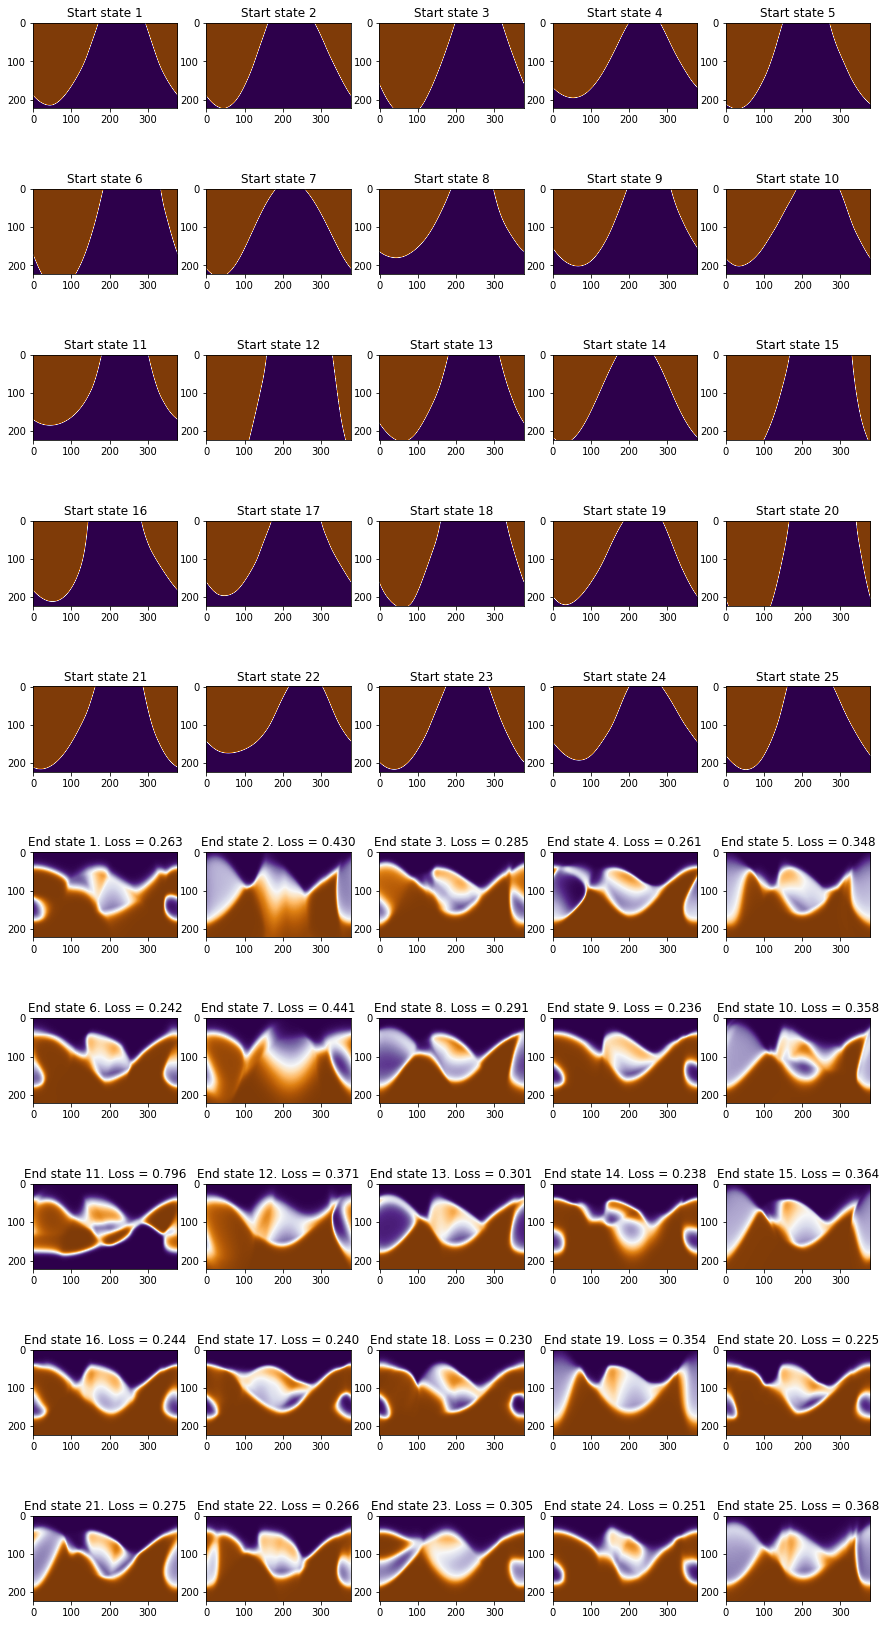

In [6]:
NUMBER_OF_EPOCHS = 2e+3
NUM_TESTS = 5
LR = 1e-3

dataset = MyData(path_to_file='./imgs/2.png', mode='img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
dataset_list = [dataset]

model = Net(dataset_list=dataset_list, lr=LR)

model.to(device)


gs = gridspec.GridSpec(2 * NUM_TESTS, NUM_TESTS)


plt.figure(figsize=(15, 30))
for i in range(NUM_TESTS ** 2):
    model = model.restart_model(lr=LR)
    model.apply(weights_init_uniform)
    start_state = model.test_model()
    model.start_training(num_epochs=NUMBER_OF_EPOCHS, my_weight=0.1, need_plot=False, need_save=False)
    end_state = model.test_model()

    # start_state = end_state = [torch.zeros(dataset.img_array.shape).flatten()]

    plt.subplot(gs[i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(start_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    plt.title(f'Start state {i+1}')

    plt.subplot(gs[NUM_TESTS + i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(end_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    loss = model.loss_dict['loss'][-1]
    plt.title(f'End state {i + 1}. Loss = {loss:.3f}')

    print(f'Stage {i+1}/{NUM_TESTS ** 2} is done! Loss = {loss:.3f}')

### $\mathcal{U}[-1,1]$

In [7]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(-1.0, 1.0)
        m.bias.data.fill_(0)

Stage 1/25 is done! Loss = 0.168
Stage 2/25 is done! Loss = 0.145
Stage 3/25 is done! Loss = 0.184
Stage 4/25 is done! Loss = 0.143
Stage 5/25 is done! Loss = 0.151
Stage 6/25 is done! Loss = 0.141
Stage 7/25 is done! Loss = 0.141
Stage 8/25 is done! Loss = 0.325
Stage 9/25 is done! Loss = 0.148
Stage 10/25 is done! Loss = 0.153
Stage 11/25 is done! Loss = 0.154
Stage 12/25 is done! Loss = 0.154
Stage 13/25 is done! Loss = 0.145
Stage 14/25 is done! Loss = 0.144
Stage 15/25 is done! Loss = 0.158
Stage 16/25 is done! Loss = 0.129
Stage 17/25 is done! Loss = 0.322
Stage 18/25 is done! Loss = 0.894
Stage 19/25 is done! Loss = 0.352
Stage 20/25 is done! Loss = 0.164
Stage 21/25 is done! Loss = 0.134
Stage 22/25 is done! Loss = 0.165
Stage 23/25 is done! Loss = 0.331
Stage 24/25 is done! Loss = 0.202
Stage 25/25 is done! Loss = 0.131


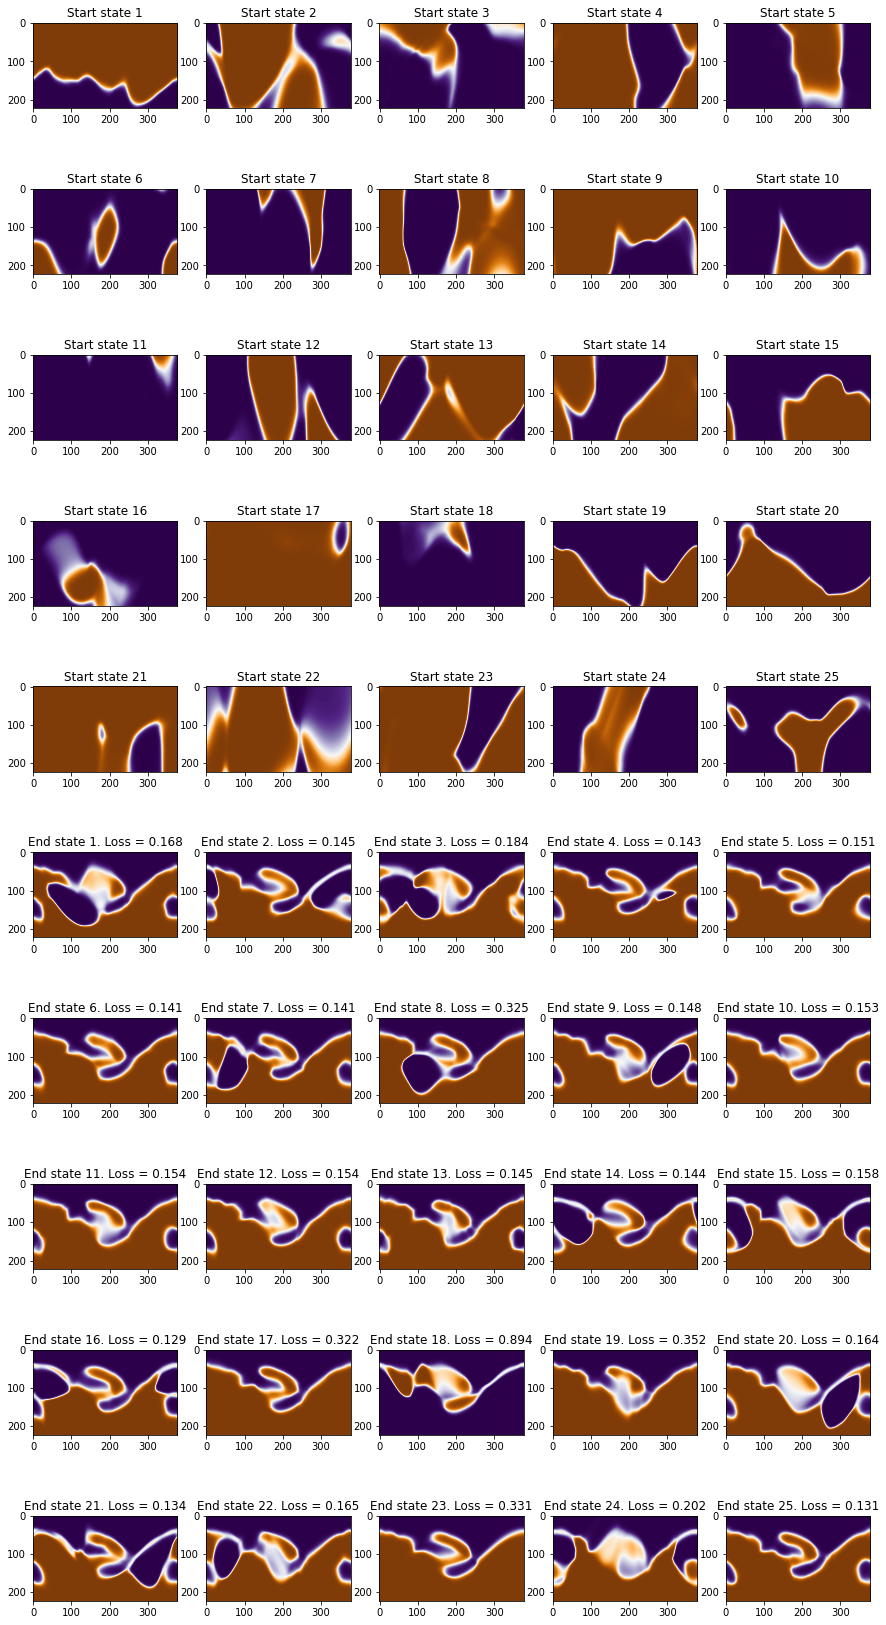

In [8]:
NUMBER_OF_EPOCHS = 2e+3
NUM_TESTS = 5
LR = 1e-3

dataset = MyData(path_to_file='./imgs/2.png', mode='img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
dataset_list = [dataset]

model = Net(dataset_list=dataset_list, lr=LR)

model.to(device)


gs = gridspec.GridSpec(2 * NUM_TESTS, NUM_TESTS)


plt.figure(figsize=(15, 30))
for i in range(NUM_TESTS ** 2):
    model = model.restart_model(lr=LR)
    model.apply(weights_init_uniform)
    start_state = model.test_model()
    model.start_training(num_epochs=NUMBER_OF_EPOCHS, my_weight=0.1, need_plot=False, need_save=False)
    end_state = model.test_model()

    # start_state = end_state = [torch.zeros(dataset.img_array.shape).flatten()]

    plt.subplot(gs[i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(start_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    plt.title(f'Start state {i+1}')

    plt.subplot(gs[NUM_TESTS + i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(end_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    loss = model.loss_dict['loss'][-1]
    plt.title(f'End state {i + 1}. Loss = {loss:.3f}')

    print(f'Stage {i+1}/{NUM_TESTS ** 2} is done! Loss = {loss:.3f}')

### $\mathcal{U}[-0.5,0.5]$


In [9]:
def weights_init_uniform_center(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a centered, uniform distribution to the weights
        m.weight.data.uniform_(-0.5, 0.5)
        m.bias.data.fill_(0)

Stage 1/25 is done! Loss = 0.189
Stage 2/25 is done! Loss = 0.146
Stage 3/25 is done! Loss = 0.157
Stage 4/25 is done! Loss = 0.149
Stage 5/25 is done! Loss = 0.166
Stage 6/25 is done! Loss = 0.175
Stage 7/25 is done! Loss = 0.149
Stage 8/25 is done! Loss = 0.179
Stage 9/25 is done! Loss = 0.160
Stage 10/25 is done! Loss = 0.340
Stage 11/25 is done! Loss = 0.145
Stage 12/25 is done! Loss = 0.186
Stage 13/25 is done! Loss = 0.161
Stage 14/25 is done! Loss = 0.172
Stage 15/25 is done! Loss = 0.156
Stage 16/25 is done! Loss = 0.151
Stage 17/25 is done! Loss = 0.185
Stage 18/25 is done! Loss = 0.171
Stage 19/25 is done! Loss = 0.172
Stage 20/25 is done! Loss = 0.137
Stage 21/25 is done! Loss = 0.166
Stage 22/25 is done! Loss = 0.147
Stage 23/25 is done! Loss = 0.336
Stage 24/25 is done! Loss = 0.168
Stage 25/25 is done! Loss = 0.182


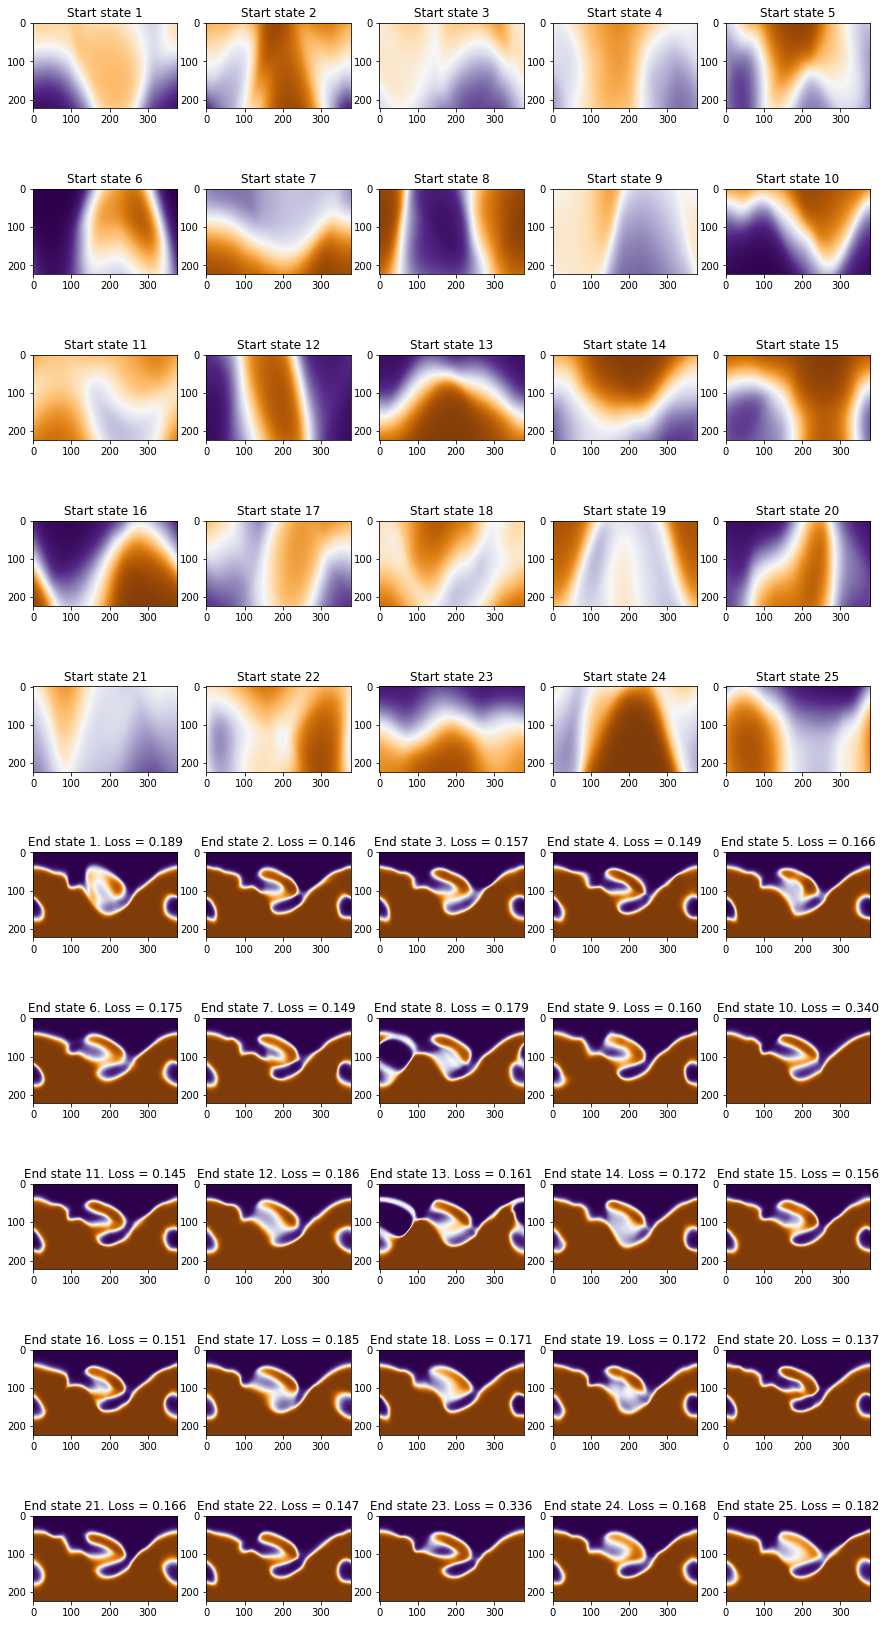

In [10]:
NUMBER_OF_EPOCHS = 2e+3
NUM_TESTS = 5
LR = 1e-3

dataset = MyData(path_to_file='./imgs/2.png', mode='img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
dataset_list = [dataset]

model = Net(dataset_list=dataset_list, lr=LR)

model.to(device)


gs = gridspec.GridSpec(2 * NUM_TESTS, NUM_TESTS)


plt.figure(figsize=(15, 30))
for i in range(NUM_TESTS ** 2):
    model = model.restart_model(lr=LR)
    model.apply(weights_init_uniform_center)
    start_state = model.test_model()
    model.start_training(num_epochs=NUMBER_OF_EPOCHS, my_weight=0.1, need_plot=False, need_save=False)
    end_state = model.test_model()

    # start_state = end_state = [torch.zeros(dataset.img_array.shape).flatten()]

    plt.subplot(gs[i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(start_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    plt.title(f'Start state {i+1}')

    plt.subplot(gs[NUM_TESTS + i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(end_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    loss = model.loss_dict['loss'][-1]
    plt.title(f'End state {i + 1}. Loss = {loss:.3f}')

    print(f'Stage {i+1}/{NUM_TESTS ** 2} is done! Loss = {loss:.3f}')

### $\mathcal{U}[-y,y]$ with $y = \frac{1}{\sqrt n}$ where n is the number of inputs to a neuron (general rule)

In [11]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

Stage 1/25 is done! Loss = 0.356
Stage 2/25 is done! Loss = 0.191
Stage 3/25 is done! Loss = 0.193
Stage 4/25 is done! Loss = 0.196
Stage 5/25 is done! Loss = 0.157
Stage 6/25 is done! Loss = 0.187
Stage 7/25 is done! Loss = 0.168
Stage 8/25 is done! Loss = 0.194
Stage 9/25 is done! Loss = 0.182
Stage 10/25 is done! Loss = 0.197
Stage 11/25 is done! Loss = 0.179
Stage 12/25 is done! Loss = 0.171
Stage 13/25 is done! Loss = 0.174
Stage 14/25 is done! Loss = 0.179
Stage 15/25 is done! Loss = 0.201
Stage 16/25 is done! Loss = 0.182
Stage 17/25 is done! Loss = 0.176
Stage 18/25 is done! Loss = 0.179
Stage 19/25 is done! Loss = 0.337
Stage 20/25 is done! Loss = 0.169
Stage 21/25 is done! Loss = 0.203
Stage 22/25 is done! Loss = 0.183
Stage 23/25 is done! Loss = 0.165
Stage 24/25 is done! Loss = 0.200
Stage 25/25 is done! Loss = 0.175


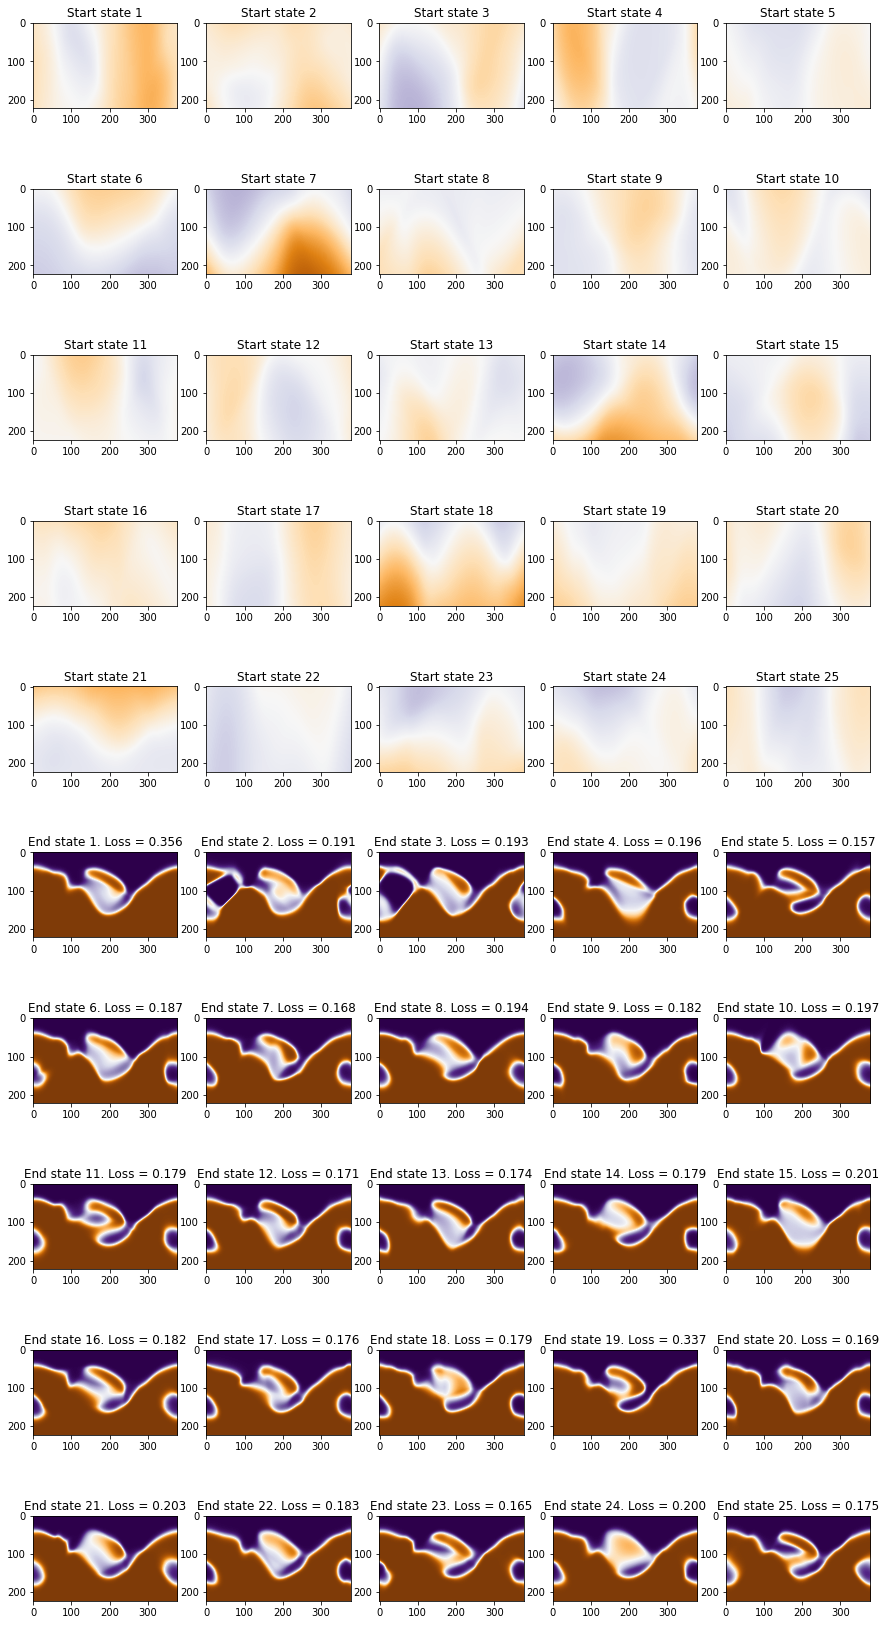

In [12]:
NUMBER_OF_EPOCHS = 2e+3
NUM_TESTS = 5
LR = 1e-3

dataset = MyData(path_to_file='./imgs/2.png', mode='img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
dataset_list = [dataset]

model = Net(dataset_list=dataset_list, lr=LR)

model.to(device)


gs = gridspec.GridSpec(2 * NUM_TESTS, NUM_TESTS)


plt.figure(figsize=(15, 30))
for i in range(NUM_TESTS ** 2):
    model = model.restart_model(lr=LR)
    model.apply(weights_init_uniform_rule)
    start_state = model.test_model()
    model.start_training(num_epochs=NUMBER_OF_EPOCHS, my_weight=0.1, need_plot=False, need_save=False)
    end_state = model.test_model()

    # start_state = end_state = [torch.zeros(dataset.img_array.shape).flatten()]

    plt.subplot(gs[i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(start_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    plt.title(f'Start state {i+1}')

    plt.subplot(gs[NUM_TESTS + i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(end_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    loss = model.loss_dict['loss'][-1]
    plt.title(f'End state {i + 1}. Loss = {loss:.3f}')

    print(f'Stage {i+1}/{NUM_TESTS ** 2} is done! Loss = {loss:.3f}')

### $\mathcal{N}(0, \frac{1}{{\sqrt n}}) $

In [13]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0,1/np.sqrt(y))
        m.bias.data.fill_(0)

Stage 1/25 is done! Loss = 0.149
Stage 2/25 is done! Loss = 0.135
Stage 3/25 is done! Loss = 0.143
Stage 4/25 is done! Loss = 0.144
Stage 5/25 is done! Loss = 0.148
Stage 6/25 is done! Loss = 0.143
Stage 7/25 is done! Loss = 0.188
Stage 8/25 is done! Loss = 0.171
Stage 9/25 is done! Loss = 0.157
Stage 10/25 is done! Loss = 0.168
Stage 11/25 is done! Loss = 0.162
Stage 12/25 is done! Loss = 0.349
Stage 13/25 is done! Loss = 0.334
Stage 14/25 is done! Loss = 0.156
Stage 15/25 is done! Loss = 0.140
Stage 16/25 is done! Loss = 0.192
Stage 17/25 is done! Loss = 0.149
Stage 18/25 is done! Loss = 0.172
Stage 19/25 is done! Loss = 0.146
Stage 20/25 is done! Loss = 0.142
Stage 21/25 is done! Loss = 0.174
Stage 22/25 is done! Loss = 0.167
Stage 23/25 is done! Loss = 0.153
Stage 24/25 is done! Loss = 0.188
Stage 25/25 is done! Loss = 0.136


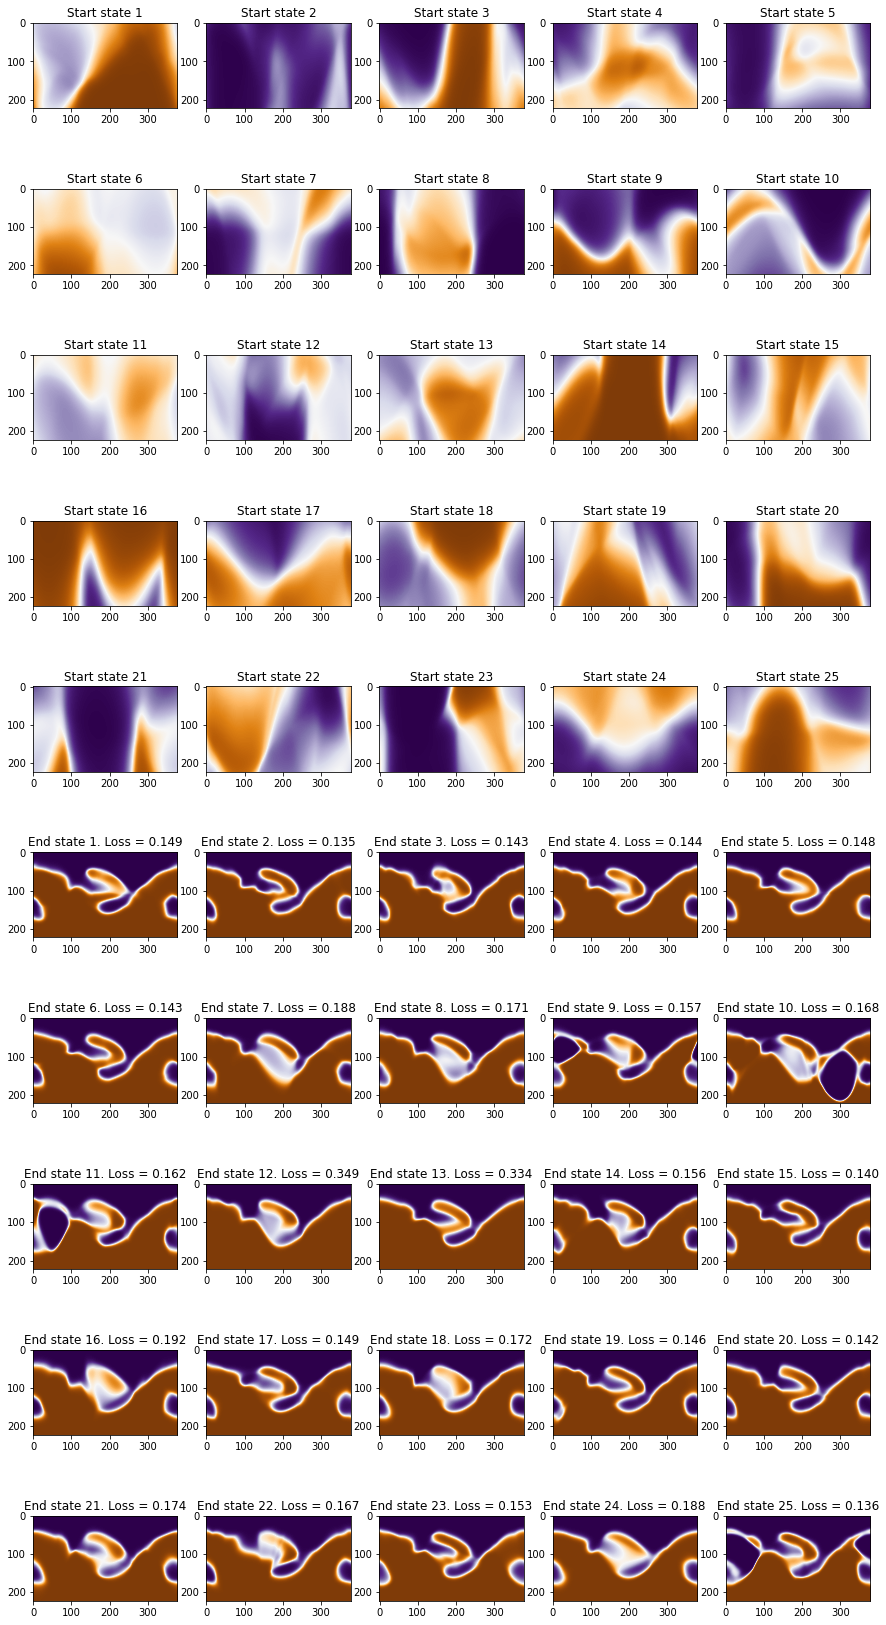

In [14]:
NUMBER_OF_EPOCHS = 2e+3
NUM_TESTS = 5
LR = 1e-3

dataset = MyData(path_to_file='./imgs/2.png', mode='img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
dataset_list = [dataset]

model = Net(dataset_list=dataset_list, lr=LR)

model.to(device)


gs = gridspec.GridSpec(2 * NUM_TESTS, NUM_TESTS)


plt.figure(figsize=(15, 30))
for i in range(NUM_TESTS ** 2):
    model = model.restart_model(lr=LR)
    model.apply(weights_init_normal)
    start_state = model.test_model()
    model.start_training(num_epochs=NUMBER_OF_EPOCHS, my_weight=0.1, need_plot=False, need_save=False)
    end_state = model.test_model()

    # start_state = end_state = [torch.zeros(dataset.img_array.shape).flatten()]

    plt.subplot(gs[i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(start_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    plt.title(f'Start state {i+1}')

    plt.subplot(gs[NUM_TESTS + i // NUM_TESTS, i % NUM_TESTS])
    plt.imshow(end_state[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
    # plt.colorbar(orientation='horizontal')
    loss = model.loss_dict['loss'][-1]
    plt.title(f'End state {i + 1}. Loss = {loss:.3f}')

    print(f'Stage {i+1}/{NUM_TESTS ** 2} is done! Loss = {loss:.3f}')